# Análise dos números da Mega Sena

Projeto adaptado para trabalhar com as versões mais recentes do sorteio.

* <b>Parte 1:</b> Análise Exploratória dos Dados <br>
* <b>Parte 2:</b> Testes Estatísticos <br>

site: http://loterias.caixa.gov.br/wps/portal/loterias/landing/megasena/

## Análise Exploratória dos Dados

Vamos focar a análise nos números sorteados, desconsiderando as informações de arrecadação e premiações.
A ideia é brincar um pouco com os sorteios e encontrar uma lógica para gerar um jogo vencedor!

Será que é possível? Vamos ver!

In [1]:
lib_path = 'C:\\Users\Admin\\Documents\\samuel\\github\\estatistica-megasena\\venv\\Lib\\site-packages'

import sys
sys.path.append(lib_path)

In [2]:
# Importação dos pacotes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Importando funções criadas para o projeto
from analysis.functions import download_raffle_file
from analysis.functions import transform_html_to_csv
from analysis.functions import pre_process_dataframe
from analysis.functions import get_data_dir
from analysis.functions import print_frequency_report

### Nessa primeira etapa, vamos apenar baixar os dados e extrair as colunas de interesse!

In [3]:
# Definindo o caminho do download
DOWNLOAD_PATH = 'http://www1.caixa.gov.br/loterias/_arquivos/loterias/D_megase.zip'
FILENAME = 'raffle.html'

# Acessando o diretório de trabalho
SAVE_PATH = get_data_dir()

In [4]:
# Fazendo download do arquivo atualizado
download_raffle_file(url=DOWNLOAD_PATH, path=SAVE_PATH, filename=FILENAME)

# Transformando a tabela html que vem no arquivo zip para csv
transform_html_to_csv(path=SAVE_PATH, filename=FILENAME)

In [5]:
# Criando e pré-processando o dataframe com os números.
megasena = pre_process_dataframe(filename=FILENAME, drop=['Cidade',
                                                          'UF',
                                                          'Arrecadacao_Total',
                                                          'Ganhadores_Sena',
                                                          'Rateio_Sena',
                                                          'Ganhadores_Quina',
                                                          'Rateio_Quina',
                                                          'Ganhadores_Quadra',
                                                          'Rateio_Quadra',
                                                          'Acumulado',
                                                          'Valor_Acumulado',
                                                          'Estimativa_Prêmio',
                                                          'Acumulado_Mega_da_Virada'])

In [6]:
# Definindo nome das colunas
names = ['Data', '1_n', '2_n','3_n', '4_n', '5_n', '6_n']

In [7]:
# Alterando os nomes para facilitar a manipulação
megasena.columns = names

# Vizualizando as primeiras linhas
megasena.head() 

,Data,1_n,2_n,3_n,4_n,5_n,6_n
Concurso,,,,,,,
1,1996-11-03,41,5,4,52,30,33
2,1996-03-18,9,39,37,49,43,41
3,1996-03-25,36,30,10,11,29,47
4,1996-01-04,6,59,42,27,1,5
5,1996-08-04,1,19,46,6,16,2


### Agora, vamos tentar buscar um pouco de informação nos dados para gerar alguns jogos
Será que conseguimos acertar os números de algum sorteio dessa forma?

In [8]:
# Vamos extrair os sorteios para verificar se algum dos jogos que foram gerados já foram sorteados em alguma oportunidade.
sorteios = []

for i in range(1, len(megasena) + 1):
    sorteios.append(list(megasena.loc[i, '1_n':'6_n'].values))

# Colocando os números em ordem para facilitar a avaliação
for sorteio in sorteios:
    sorteio.sort()

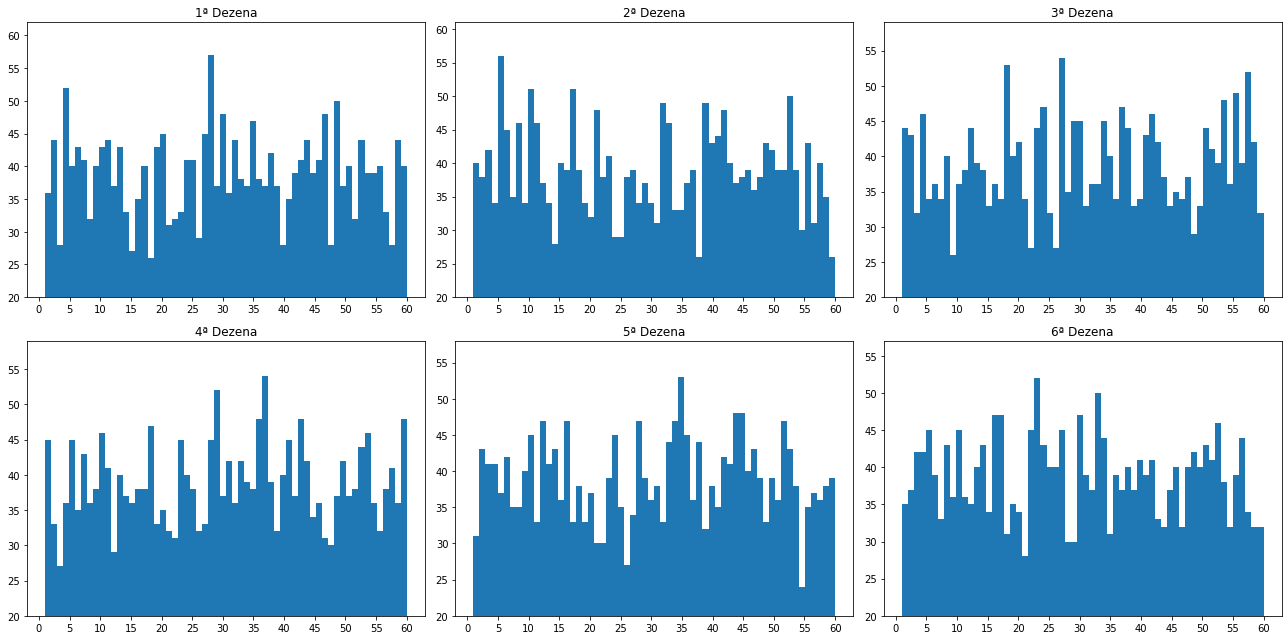

In [9]:
# Avaliando a distribuição de frêquencia entre os números sorteados em cada dezena
mega_dezenas = megasena.loc[:, '1_n':'6_n']

plt.figure(figsize=(18,9))

for i, n in enumerate(mega_dezenas.columns):
    plt.subplot(231+i)
    plt.hist(mega_dezenas[n], bins=60)
    plt.xticks(range(0, 61, 5))
    plt.yticks(range(20, mega_dezenas[n].value_counts().max()+5, 5))
    plt.ylim(20, mega_dezenas[n].value_counts().max()+5)
    plt.title(f'{i+1}ª Dezena')

plt.tight_layout()

In [10]:
# Agora, vamos criar alguns jogos baseados na frequencia de sorteio de cada número.
# Jogos com os números mais frequentes:

jogos_mais_frequentes = []

print()
for i, col in enumerate(mega_dezenas.columns):
    jogos_mais_frequentes.append(mega_dezenas[col].value_counts().head(6).index.to_list())
    print(f'{i+1}ª Dezena: {mega_dezenas[col].value_counts().head(6).index.to_list()}', end='\n\n')
    print('-=' * 20, end='\n\n')

# Colocando os números em ordem para facilitar a avaliação
for jogo in jogos_mais_frequentes:
    jogo.sort()


1ª Dezena: [28, 4, 49, 47, 30, 35]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

2ª Dezena: [5, 10, 17, 53, 32, 39]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

3ª Dezena: [27, 18, 58, 56, 54, 37]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

4ª Dezena: [37, 29, 60, 36, 43, 18]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

5ª Dezena: [35, 45, 44, 28, 12, 34]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

6ª Dezena: [23, 33, 16, 30, 17, 53]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



In [11]:
# Jogos com os números mais frequentes por dezena:
jogos_menos_frequentes = []

print()
for i, col in enumerate(mega_dezenas.columns):
    jogos_menos_frequentes.append(mega_dezenas[col].value_counts(ascending=True).head(6).index.to_list())
    print(f'{i+1}ª Dezena: {mega_dezenas[col].value_counts(ascending=True).head(6).index.to_list()}', end='\n\n')
    print('-=' * 20, end='\n\n')
    
# Colocando os números em ordem para facilitar a avaliação
for jogo in jogos_menos_frequentes:
    jogo.sort()


1ª Dezena: [18, 15, 48, 58, 3, 40]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

2ª Dezena: [38, 60, 14, 24, 25, 55]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

3ª Dezena: [9, 26, 22, 49, 60, 3]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

4ª Dezena: [3, 12, 48, 22, 47, 21]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

5ª Dezena: [55, 26, 22, 21, 1, 39]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

6ª Dezena: [21, 29, 28, 35, 18, 60]

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



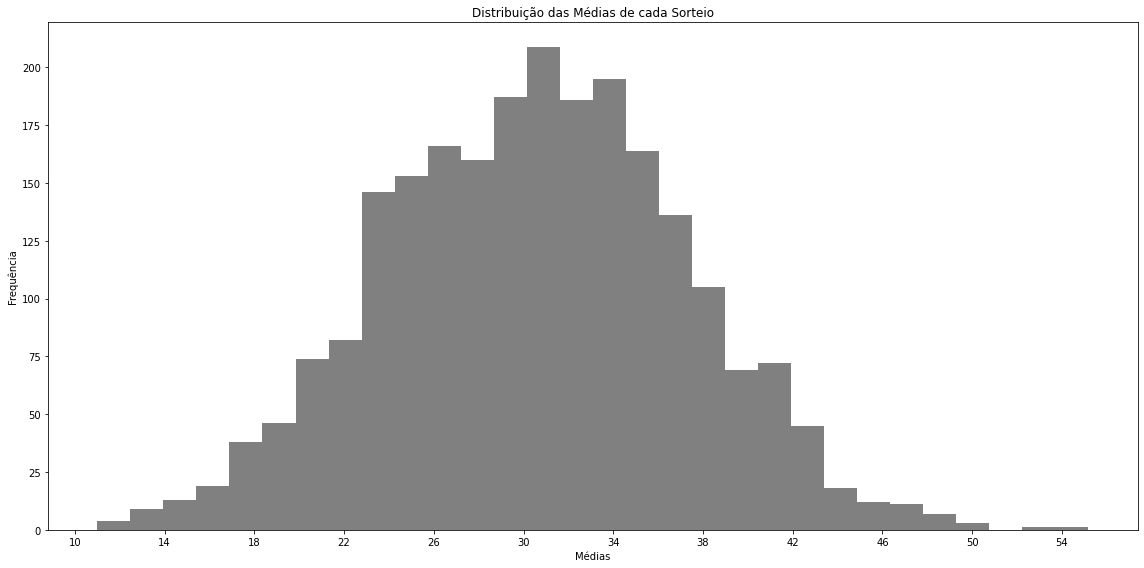

In [12]:
# Avaliando a distribuição das médias entre os 6 números sorteados em cada sorteio.

plt.figure(figsize=(16,8))
plt.hist(mega_dezenas.agg(func=['mean'], axis=1)['mean'], bins=30, color='gray')
plt.xticks(range(10, 58, 4))
plt.title('Distribuição das Médias de cada Sorteio')
plt.xlabel('Médias')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

In [13]:
# Preparando o dataset para avaliação geral dos números
dezenas = mega_dezenas.reset_index(level=0)

dezenas = dezenas.melt(id_vars='Concurso',
                       value_vars=['1_n', '2_n', '3_n', '4_n', '5_n', '6_n'],
                       var_name='Dezena',
                       value_name='Numero')

dezenas.sort_values(['Concurso', 'Dezena']).reset_index(drop=True).head(12)

,Concurso,Dezena,Numero
0,1,1_n,41
1,1,2_n,5
2,1,3_n,4
3,1,4_n,52
4,1,5_n,30
5,1,6_n,33
6,2,1_n,9
7,2,2_n,39
8,2,3_n,37
9,2,4_n,49


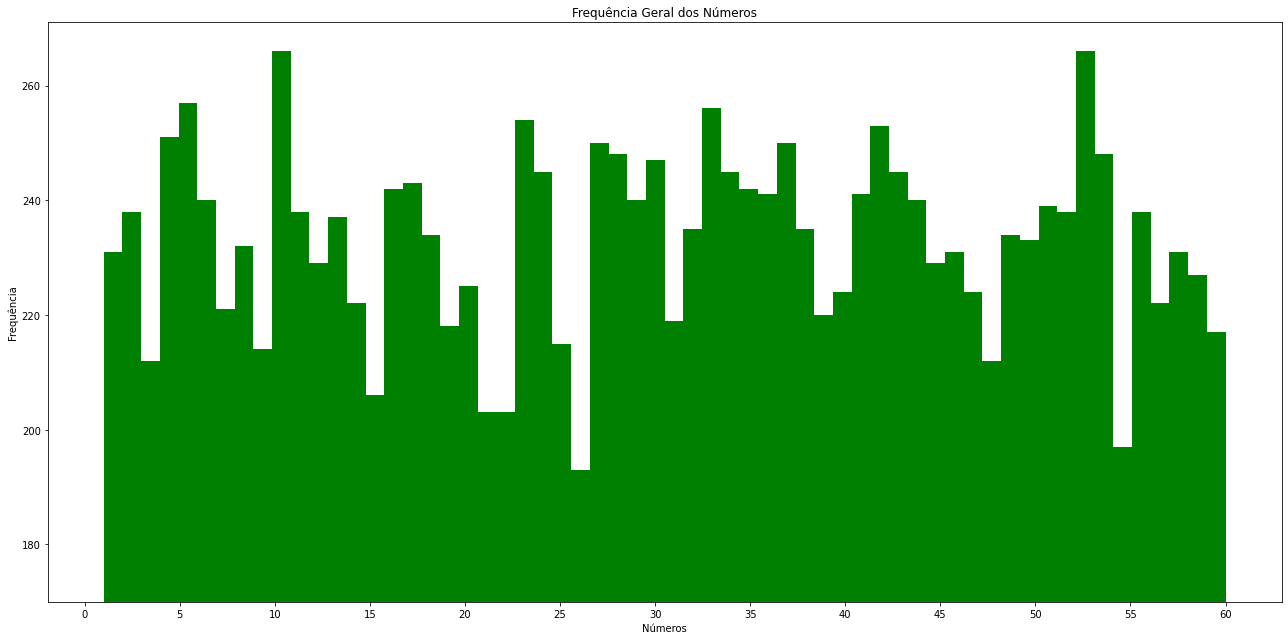

In [14]:
# Avaliando a distribuição de frequência geral dos números, descartando a dezena em que foi sorteado.
y_lim = dezenas.Numero.value_counts().max() + 5

plt.figure(figsize=(18,9))
plt.hist(dezenas['Numero'], bins=60, color='green')
plt.xticks(range(0, 61, 5))
plt.ylim(170, y_lim)
plt.title('Frequência Geral dos Números')
plt.xlabel('Números')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

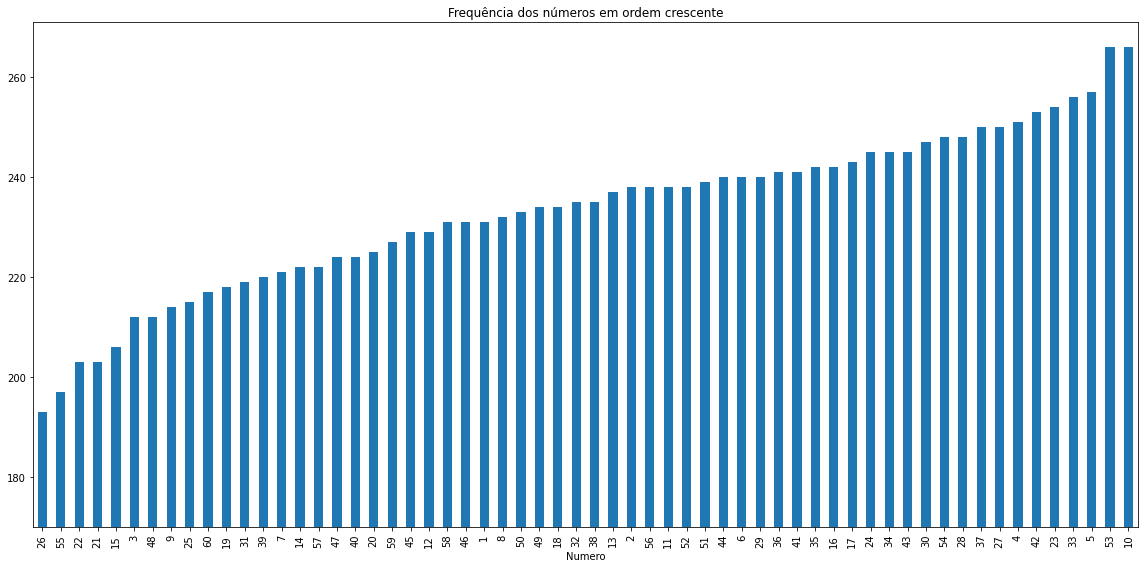

In [15]:
# Organizando o gráfico em ordem crescente de frequência

freq = dezenas.groupby('Numero').count().iloc[:,0]

plt.figure(figsize=(16,8))
freq.sort_values().plot(kind='bar')
plt.title('Frequência dos números em ordem crescente')
plt.ylim(170, y_lim)
plt.tight_layout()
plt.show()

In [16]:
print_frequency_report(frequency_dataframe=freq)

OS NÚMEROS QUE MAIS APARECERAM FORAM:

10 que apareceu em 266 sorteios
53 que apareceu em 266 sorteios
5 que apareceu em 257 sorteios
33 que apareceu em 256 sorteios
23 que apareceu em 254 sorteios
42 que apareceu em 253 sorteios

OS NÚMEROS QUE MENOS APARECERAM FORAM:

26 que apareceu em 193 sorteios
55 que apareceu em 197 sorteios
22 que apareceu em 203 sorteios
21 que apareceu em 203 sorteios
15 que apareceu em 206 sorteios
3 que apareceu em 212 sorteios

Jogo com números mais frequentes: [5, 10, 23, 33, 42, 53]
Jogo com números menos frequentes: [3, 15, 21, 22, 26, 55]


In [17]:
# Finalizamos então com 14 jogos,
# 12 para a maior e menor frequencia dos números em cada dezena
# Além do maior e menor descartando a ordem que apareceu.

geral = [[4, 5, 10, 23, 33, 53], [3, 15, 21, 22, 26, 55]]


# Vamos juntar todos os jogos!
# Será que algum deles já foi sorteado?

todos_os_jogos = [jogos_mais_frequentes, jogos_menos_frequentes, geral]

In [18]:
# Checando todos os jogos
for jogos in todos_os_jogos:
    for jogo in jogos:
        if jogo in sorteios:
            print('Temos um vencedor!!!', jogo)
            break
        else:
            print('Esse jogo nunca foi sorteado:', jogo)          

Esse jogo nunca foi sorteado: [4, 28, 30, 35, 47, 49]
Esse jogo nunca foi sorteado: [5, 10, 17, 32, 39, 53]
Esse jogo nunca foi sorteado: [18, 27, 37, 54, 56, 58]
Esse jogo nunca foi sorteado: [18, 29, 36, 37, 43, 60]
Esse jogo nunca foi sorteado: [12, 28, 34, 35, 44, 45]
Esse jogo nunca foi sorteado: [16, 17, 23, 30, 33, 53]
Esse jogo nunca foi sorteado: [3, 15, 18, 40, 48, 58]
Esse jogo nunca foi sorteado: [14, 24, 25, 38, 55, 60]
Esse jogo nunca foi sorteado: [3, 9, 22, 26, 49, 60]
Esse jogo nunca foi sorteado: [3, 12, 21, 22, 47, 48]
Esse jogo nunca foi sorteado: [1, 21, 22, 26, 39, 55]
Esse jogo nunca foi sorteado: [18, 21, 28, 29, 35, 60]
Esse jogo nunca foi sorteado: [4, 5, 10, 23, 33, 53]
Esse jogo nunca foi sorteado: [3, 15, 21, 22, 26, 55]


Nem com toda essa lógica conseguimos acertar um jogo.<br>
E ainda, tentamos em mais de 2300 sorteios.

É tão díficil assim ganhar na Megasena?
Vamos fazer alguns testes.

## Testes Estatíscos:

* Vamos tentar entender as dificuldades em conseguir sair com o prêmio principal?
* Vamos validar a tabela de probabilidades da Caixa Econômica Federal?

In [19]:
# Importando a classe "Gambler" criada para esse projeto
# Essa classe simula um apostador.

from statistics.gambler import Gambler

#### Para criarmos a classe apostador, precisamos definir alguns parametros:

* <b>intervalo_numeros</b> = Intevalo de números aleatórios(Ex: MegaSena = 60)<br>
* <b>quantidade_numeros_sorteados</b> = Quantidade de números a serem sorteados (Ex: MegaSena = 6)<br>
* <b>quantidade_numeros_jogados</b> = Quantidade de números escolhidos para jogar (Ex: MegaSena de 6 até 15)<br>
* <b>jogos_por_jogador</b> = Quantidade de jogos aleatórios para tentar acertar o sorteio<br>

Dessa forma, podemos validar outros tipos de jogos e sorteios.<br>
Nesse caso, vamos focar apenas na megasena.<br>

In [20]:
# Definindo as regras do sorteio
intervalo_numeros = 60              
quantidade_numeros_sorteados = 6    

In [21]:
# Definindo como serão nossos jogos
quantidade_numeros_jogados = 6      
jogos_por_jogador = 1

In [22]:
# Instanciando a classe com os parametros definidos anteriormente
gambler = Gambler(numbers_range=intervalo_numeros,
                  numbers_amount=quantidade_numeros_sorteados,
                  numbers_played=quantidade_numeros_jogados,
                  trials=jogos_por_jogador)

In [23]:
# Com a classe instanciada, conseguimos acessar algumas informações, como o número sorteado.
# Prodemos sobrescrever esse número se for necessário.

# Nesse exemplo, temos o sorteio, os jogos feitos pelo apostador e a quantidade de acertos por jogo.
# Nesse caso, temos apenas um jogo, mas podemos aumentar para quantos quisermos.

print(f'Sorteio: {gambler.raffle_numbers}')
print(f'Aposta: {gambler.gamble()[0]}')
print(f'Acertos: {gambler.check_hits()}')

Sorteio: [8, 30, 21, 36, 28, 34]
Aposta: [10, 28, 18, 1, 15, 13]
Acertos: [1]


In [24]:
# Agora, vamos tentar 100 vezes.
jogos_por_jogador = 100

In [25]:
# Vamos instanciar a classe novamente, agora usando 100 jogos por jogador.
gambler = Gambler(numbers_range=intervalo_numeros,
                  numbers_amount=quantidade_numeros_sorteados,
                  numbers_played=quantidade_numeros_jogados,
                  trials=jogos_por_jogador)

In [26]:
# Como o relatório ficaria muito grande, criamos uma função que avalia todos os jogos e retorna nosso resultado.
gambler.play()


That´s SAD! We tried 100 time(s), but we didn't hit all the 6 numbers!
Our best game just hit 3 number(s)!


Não conseguimos acertar nem com 100 tentativas. <br>
Será que conseguimos com 1 milhão?

In [27]:
# Vamos tentar novamente, agora com 1.000.000 de tentativas.
jogos_por_jogador = 1_000_000

gambler = Gambler(numbers_range=intervalo_numeros,
                  numbers_amount=quantidade_numeros_sorteados,
                  numbers_played=quantidade_numeros_jogados,
                  trials=jogos_por_jogador)

gambler.play()


That´s SAD! We tried 1,000,000 time(s), but we didn't hit all the 6 numbers!
Our best game just hit 5 number(s)!


-------------

Já chegamos mais perto, mas mesmo assim não foi o suficiente. <br>
Vamos pedir ajuda ao reporter especializado em jogos e a um clube de apostadores para ver qual a real dificuldade de se vencer nesse jogo<br>


A ideia aqui foi criar uma classe espefícia para gerar os relatórios e outra, para criar uma amostragem significativa o suficiente para validar os resultados que tivermos.<br>

Na "GamblersClub" (Clube de Apostadores) foi adicionado um argumento para definir o número de jogadores (número de amostras) mas a feature mais interessante é que a classe foi otimizada para realizar o processamento das amostras em pararelo, com um ganho bem expressivo de performance:

* <b><u>6 horas</b></u>: Nenhum tipo de otimização
* <b><u>2 horas</b></u>: Paralelizado com CPU de 4 núcleos
* <b><u>menos de 1 hora</b></u>: Paralelizado com CPU de 8 núcleos

Esses foram os tempos de processamento para gerar 30 amostras com 100.000.000 de tentativas cada. <br><br>

In [28]:
# Importando a classe Reporter criada para esse projeto
from magazine.reporter import Reporter

In [29]:
# Instanciando a classe
reporter = Reporter()

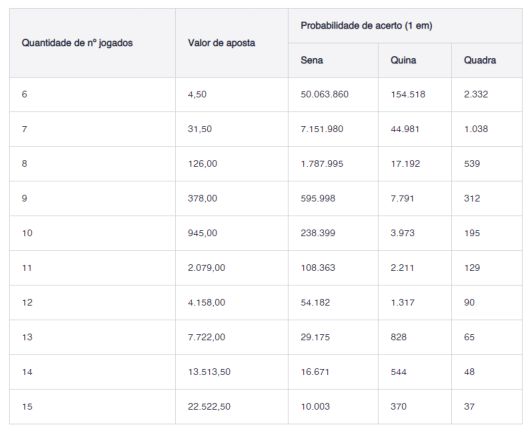

In [30]:
# Checando a tabela de probabilidades divulgado pela CEF
reporter.show_probabilities_image()

Para cada quantidade de números jogados, nós geramos 30 amostras com uma quantidade de tentativas alinhada com as chances de acerto. A ideia era ter um número grande o suficiente para ter ao menos 2 acertos na sena.

Mesmo com o processo otimizado para processar os jogos paralelamente, o tempo de processamento é relativamente alto, por isso, salvei as listas para facilitar o acesso.

todos as 15 amostras estão disponíveis através do link: <a href="https://drive.google.com/file/d/1YB0MuOw2fg49e7cI18ygeWbGSWiVxQvn/view?usp=sharing">SAMPLES</a>

Um ponto interessante que surgiu no momento de armazenar os dados, foi que como uma matriz numpy o tamanho das amostras excedeu bastante as minhas expectativas. Como solução, usei a biblioteca `joblib` para salvar os dados no formato pickle e tivemos uma redução bastante significativa.

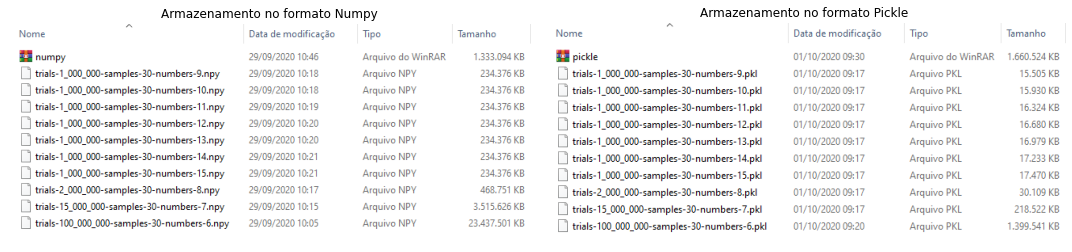

In [31]:
import matplotlib.pyplot as plt

numpy = plt.imread('data/numpy.png')
pickle = plt.imread('data/pickle.png')

plt.figure(figsize=(15,10))

plt.subplot(121)
plt.axis('off')
plt.title('Armazenamento no formato Numpy')
plt.imshow(numpy)

plt.subplot(122)
plt.axis('off')
plt.title('Armazenamento no formato Pickle')
plt.imshow(pickle)

plt.tight_layout()
plt.show()

Para exemplificar qual seria o processo para gerar as amostras, vamos demonstrar a utilização da classe `GamblersClub`.
Vamos gerar uma amostra de tamanho médio e medir seu tempo.

In [32]:
from statistics.club import GamblersClub

In [33]:
intervalo_numeros = 60              #Intevalo de números aleatórios(Ex: MegaSena = 60)
quantidade_numeros_sorteados = 6    #Quantidade de números a serem sorteados (Ex: MegaSena = 6)
quantidade_numeros_jogados = 6      #Quantidade de números escolhidos para jogar (Ex: MegaSena de 6 até 15)
jogos_por_jogador = 1_000_000       #Quantidade de jogos aleatórios para tentar acertar o sorteio
jogadores = 10                      #Quantidade de repetições para gerar um amostra estatística

In [34]:
gamblers = GamblersClub(numbers_range=intervalo_numeros,
                        numbers_amount=quantidade_numeros_sorteados,
                        numbers_played=quantidade_numeros_jogados,
                        trials=jogos_por_jogador,
                        players=jogadores)

In [35]:
%time gamblers.play()

Wall time: 33.3 s


Para finalizar, vamos solicitar ao reporter que verifique as amostras e nos gere um relatório sobre nossos resultados comparados com a tabela de probabilidades. 

Também vamos solicitar um intervalo de confiança para avaliar esses números.

In [36]:
path = 'data/trials-15_000_000-samples-30-numbers-7.pkl'
%time reporter.load_hits(path)

Wall time: 9.25 s


In [37]:
%time reporter.hit_report(number=4)

The mean score was approximately 14,430 each 15,000,000 trials:

1 hit each 1,039 games played!
We have played with 7 numbers.

the raffler says: 1,038
Wall time: 1min 1s


In [38]:
%time reporter.confidence_report(number=4, confidence=0.99)

A média da quantidade de acertos foi de 14396 até 14469 considerando 99% de confiança
Wall time: 58.1 s


In [39]:
%time reporter.hit_report(number=5)

The mean score was approximately 338 each 15,000,000 trials:

1 hit each 44,378 games played!
We have played with 7 numbers.

the raffler says: 44,981
Wall time: 58.1 s


In [40]:
%time reporter.confidence_report(number=5, confidence=95)

A média da quantidade de acertos foi de 332 até 343 considerando 95% de confiança
Wall time: 57.9 s


In [41]:
%time reporter.hit_report(number=6)

The mean score was approximately 1 each 15,000,000 trials:

1 hit each 15,000,000 games played!
We have played with 7 numbers.

the raffler says: 7,151,980
Wall time: 59.7 s


In [42]:
%time reporter.confidence_report(number=6, confidence=0.90)

A média da quantidade de acertos foi de 1 até 2 considerando 90% de confiança
Wall time: 1min 2s


### CONCLUSÃO:

As quantidades ficaram bem próximas da tabela, com exceção do número 6 que exigiria que mais tentativas fossem realizadas para aferir corretamente a média de jogos para conseguir uma sena.

Outro ponto interessante é que a técnica de bootstrap com uma quantidade grande de dados apresentou um gargalo no processo, onde cada relatório levou quase dois minutos para ser produzido. Essa é uma ótima oportunidade para otimização via processamento paralelo. Na próxima atualização do projeto, será o foco principal.

Agradeço de você acompanhou todo o processo.
Qualquer dúvida, estarei a disposição.

Meus contatos estão no site: <a hef="samuelbaptista.github.io">Samuel Baptista</a><br>

<b>MUITO OBRIGADO!</b> 

# FIM!